In [2]:
!git clone https://github.com/Hannibal96/ImageCaptionProject.git

fatal: destination path 'ImageCaptionProject' already exists and is not an empty directory.


In [3]:
%cd ImageCaptionProject/

/content/ImageCaptionProject


In [3]:
!git checkout razi

Branch 'razi' set up to track remote branch 'razi' from 'origin'.
Switched to a new branch 'razi'


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from data import *
from models import *
import torchvision.transforms as T
from torchtext.vocab import GloVe # for pretrained model
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

def evaluate(model, val_data_set, criterion):
    blew_score = 0
    total_val_loss = 0

    with torch.no_grad():
        for idx, (image, captions, all_caps) in tqdm(enumerate(iter(val_data_set))):
            image, captions = image.to(device), captions.to(device)

            features = model.encoder(image[0:1].to(device))
            caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
            hyp_caption = ' '.join(caps)
            curr_blew_score = sentence_bleu(references=all_caps[0], hypothesis=hyp_caption.split())
            blew_score += curr_blew_score

            outputs, attentions = model(image, captions)
            outputs = outputs.to(device)
            targets = captions[:, 1:]
            targets = targets.to(device)
            val_loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            total_val_loss += val_loss.item()

    perplexity = total_val_loss / len(val_data_set)
    perplexity = np.exp(perplexity)
    return blew_score / len(val_data_set), total_val_loss/len(val_data_set), perplexity



In [6]:
images_path = '/content/drive/MyDrive/ImageCaption/Images'
captions_file_path = "captions.txt"
karpathy_json_path = 'Karpathy_data.json'

# define the transforms to be applied which needed for the pretrained CNN
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

#build vocab
vocab = build_vocab(captions_file_path=captions_file_path)

#build datasets
train, val, test = karpathy_split(captions_file_path, karpathy_json_path)
train_dataset = FlickrDataset(root_dir=images_path,vocab= vocab, captions_df=train,transform=transforms, is_train=True)
val_dataset = FlickrDataset(root_dir=images_path,vocab= vocab, captions_df=val,transform=transforms,is_train=False)
test_dataset = FlickrDataset(root_dir=images_path,vocab= vocab, captions_df=test,transform=transforms,is_train=False)
print("Finished building the Datasets.")

BATCH_SIZE = 32

pad_idx = vocab.stoi["<PAD>"]
train_data = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0,
                        shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True))
val_data = DataLoader(dataset=val_dataset, batch_size=1, num_workers=0,
                      shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True,is_train=False))

test_data = DataLoader(dataset=test_dataset, batch_size=1, num_workers=0,
                        shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True,is_train=False))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"]).to(device)


100%|██████████| 40455/40455 [00:01<00:00, 22617.58it/s]


Finished building the Datasets.


In [7]:
def train_one_epoch(model, train_data, optimizer, criterion):
  total_loss = 0
  for idx, (image, captions) in tqdm(enumerate(iter(train_data))):
      image, captions = image.to(device), captions.to(device)

      # Zero the gradients.
      optimizer.zero_grad()

      # Feed forward
      outputs, attentions = model(image, captions)
      outputs = outputs.to(device)

      # Calculate the batch loss.
      targets = captions[:, 1:]
      targets = targets.to(device)
      loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

      # Backward pass.
      loss.backward()

      # Update the parameters in the optimizer.
      optimizer.step()

      total_loss += loss.item()
    
  return total_loss/len(train_data)

In [11]:

np.random.seed = 1 #used to compare same examples in different models
num_epochs = 20
print_every = 1000

vocab_size = len(vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 3e-4
embed_size = 300

perf = {} #will hold metrics
idxs = np.random.randint(size=10,low=0, high=len(test_dataset))#10 random idxs for plotting

for trained_embed in [True, False]:
  model_name = 'CapModel'

  weights_matrix = None
  if trained_embed:
    g = GloVe(name='840B', dim=300)
    embed_size = g.dim
    weights_matrix = load_embedding_weights(vocab, g)
    model_name += 'Pre'


  # init model
  model = EncoderDecoder(
      embed_size=embed_size,
      vocab_size=vocab_size,
      attention_dim=attention_dim,
      encoder_dim=encoder_dim,
      decoder_dim=decoder_dim,
      embedding_weights = weights_matrix
  ).to(device)

    # setup optimizer used
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, verbose=True)

  #train model
  blue_list, loss_list, perplexity_list , best_model = training_loop(model,model_name, train_data,
                                                                    val_data, scheduler, optimizer,
                                                                   criterion, print_every, num_epochs)
  perf[model_name] = {list_type:vals for list_type,vals in zip(['bleu','loss','perp'],[blue_list, loss_list, perplexity_list])}
  # Evaluate on test data:
  model.eval()
  bleu, loss, perp = evaluate(best_model, test_data, criterion)
  print('the model' + model_name + "test metrics: bleu-4={}, loss={}, perplixity={}".format(bleu,loss,perp))
  print(bleu,loss,perp)

  print('showing caption examples')
  #show examples
  for idx in idxs:
    #open image & show
    im = Image.open(images_path +'/'+ test_dataset.imgs[idx])
    plt.imshow(im)
    # transform image & generate caption
    img = transforms(im).unsqueeze(0)
    features = model.encoder(img.to(device))
    caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
    hyp_caption = ' '.join(caps[:-1]) #to string
    # get all true 5 captions for our image:
    captions1 = test_dataset.captions[np.where(test_dataset.imgs == test_dataset.imgs[idx])[0]]
    # from strings to list of words
    all_captions = captions1 = [c.split(' ') for c in captions1]
    curr_blew_score = sentence_bleu(references=all_captions, hypothesis=hyp_caption.split())
    plt.title(hyp_caption + '(BLEU-4 = {})'.format(np.round(curr_blew_score,2)))
    plt.show()




using pretrained embedding weights


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
188it [01:30,  2.07it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
3it [00:00, 24.87it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:4

average loss = 4.806871344434454


1000it [00:35, 28.41it/s]


Epoch: 1 loss: 4.158, perplexity: 63.935, BLEU: 0.585


188it [01:27,  2.15it/s]
3it [00:00, 25.23it/s]

average loss = 3.9463957801778267


1000it [00:36, 27.05it/s]


Epoch: 2 loss: 3.694, perplexity: 40.221, BLEU: 0.470


188it [01:28,  2.13it/s]
3it [00:00, 28.22it/s]

average loss = 3.6260929133029696


1000it [00:36, 27.50it/s]


Epoch: 3 loss: 3.512, perplexity: 33.513, BLEU: 0.486


188it [01:28,  2.14it/s]
3it [00:00, 26.04it/s]

average loss = 3.425504262142993


1000it [00:36, 27.57it/s]


Epoch: 4 loss: 3.318, perplexity: 27.593, BLEU: 0.461


188it [01:28,  2.14it/s]
3it [00:00, 28.24it/s]

average loss = 3.306405244989598


1000it [00:35, 28.21it/s]


Epoch: 5 loss: 3.280, perplexity: 26.580, BLEU: 0.472


188it [01:27,  2.14it/s]
3it [00:00, 28.87it/s]

average loss = 3.199342702297454


1000it [00:34, 28.93it/s]


Epoch: 6 loss: 3.160, perplexity: 23.569, BLEU: 0.505


188it [01:27,  2.14it/s]
3it [00:00, 26.50it/s]

average loss = 3.1113603191172823


1000it [00:35, 27.86it/s]


Epoch: 7 loss: 3.109, perplexity: 22.398, BLEU: 0.469


188it [01:27,  2.15it/s]
3it [00:00, 26.79it/s]

average loss = 3.035372198896205


1000it [00:35, 28.23it/s]


Epoch: 8 loss: 3.056, perplexity: 21.246, BLEU: 0.466


188it [01:28,  2.14it/s]
3it [00:00, 26.62it/s]

average loss = 3.0068846344947815


1000it [00:35, 27.85it/s]


Epoch: 9 loss: 2.997, perplexity: 20.023, BLEU: 0.457


188it [01:27,  2.15it/s]
3it [00:00, 27.75it/s]

average loss = 2.944834532889914


1000it [00:35, 28.05it/s]


Epoch: 10 loss: 2.965, perplexity: 19.397, BLEU: 0.466


188it [01:27,  2.15it/s]
3it [00:00, 26.13it/s]

average loss = 2.89409768454572


1000it [00:35, 27.90it/s]


Epoch: 11 loss: 2.915, perplexity: 18.445, BLEU: 0.444


188it [01:26,  2.16it/s]
3it [00:00, 27.71it/s]

average loss = 2.8460452797565052


1000it [00:35, 28.16it/s]


Epoch: 12 loss: 2.884, perplexity: 17.886, BLEU: 0.464


188it [01:27,  2.15it/s]
3it [00:00, 26.15it/s]

average loss = 2.8123564948426916


1000it [00:35, 28.41it/s]


Epoch: 13 loss: 2.870, perplexity: 17.642, BLEU: 0.462


188it [01:27,  2.16it/s]
4it [00:00, 30.16it/s]

average loss = 2.774179958282633


1000it [00:35, 28.13it/s]


Epoch: 14 loss: 2.834, perplexity: 17.018, BLEU: 0.462


188it [01:27,  2.14it/s]
3it [00:00, 25.51it/s]

average loss = 2.7494433750497533


1000it [00:35, 28.34it/s]


Epoch: 15 loss: 2.825, perplexity: 16.856, BLEU: 0.461


188it [01:27,  2.15it/s]
3it [00:00, 26.74it/s]

average loss = 2.706188663523248


1000it [00:35, 28.46it/s]


Epoch: 16 loss: 2.801, perplexity: 16.453, BLEU: 0.461


188it [01:26,  2.16it/s]
3it [00:00, 28.54it/s]

average loss = 2.6828830368975374


1000it [00:35, 28.46it/s]


Epoch: 17 loss: 2.774, perplexity: 16.018, BLEU: 0.464


188it [01:27,  2.15it/s]
3it [00:00, 27.36it/s]

average loss = 2.646568385844535


1000it [00:35, 28.19it/s]


Epoch: 18 loss: 2.736, perplexity: 15.422, BLEU: 0.456


188it [01:26,  2.16it/s]
3it [00:00, 27.44it/s]

average loss = 2.632990208077938


1000it [00:34, 28.87it/s]
0it [00:00, ?it/s]

Epoch: 19 loss: 2.759, perplexity: 15.789, BLEU: 0.467
Epoch    19: reducing learning rate of group 0 to 3.0000e-05.


188it [01:27,  2.16it/s]
3it [00:00, 26.63it/s]

average loss = 2.5907772335600345


1000it [00:35, 27.99it/s]


Epoch: 20 loss: 2.738, perplexity: 15.452, BLEU: 0.464
Epoch    20: reducing learning rate of group 0 to 3.0000e-06.


FileNotFoundError: ignored

In [ ]:
# Hyperparams
weights_matrix = None
# load pretrained embeddings (to train embeddings from scrach just set the embed_size)
#g = GloVe(name ='6B', dim=100)
embed_size = 300#g.dim
#weights_matrix = load_embedding_weights(vocab, g)



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# init model
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    embedding_weights = weights_matrix
).to(device)

blue_list, loss_list, perplexity_list , best_model = training_loop(model,model_name, 
              train_data, val_data, scheduler, optimizer,criterion, print_every=500, num_epochs=20)

# Evaluate on test data:
model.eval()
test_data = DataLoader(dataset=test_dataset, batch_size=1, num_workers=0,
                      shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True,is_train=False))
bleu, loss, perp = evaluate(model, test_data)
print(bleu,loss,perp)

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def save_model(model,name):
    path = name+".torch"
    torch.save(model, path)

In [9]:
def training_loop(model,model_name, train_data, val_data, scheduler, optimizer,criterion, print_every=500, num_epochs=20):
  loss_list = []
  perplexity_list = []
  bleu_list = []
  total_loss = 0
  best_loss = 1000
  for epoch in range(1, num_epochs + 1):
      model.train()
      avg_training_loss = train_one_epoch(model, train_data, optimizer, criterion)
      print('average loss = {}'.format(avg_training_loss))

      model.eval()
      bleu, loss, perp = evaluate(model, val_data, criterion)
      print("Epoch: {} loss: {:.3f}, perplexity: {:.3f}, BLEU: {:.3f}".format(epoch, loss, perp, bleu))
      # save only best model based on evaluation loss
      if loss < best_loss:
        best_loss = loss
        save_model(model,model_name)#overrides previous saved model

      # reduce LR based on evaluation loss (because BLEU is not an accurate perf estimate)
      scheduler.step(loss)
      perplexity_list.append(perp)
      loss_list.append(loss)
      bleu_list.append(bleu)

      pickle.dump(perplexity_list, open('perplexity_list.p', 'wb'))
      pickle.dump(loss_list, open('loss_list.p', 'wb'))
      pickle.dump(bleu_list, open('blew_list.p', 'wb'))
  best_model = torch.load(model_name)
  return blue_list, loss_list, perplexity_list , best_model

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
188it [21:20,  6.81s/it]
0it [00:00, ?it/s]

average loss = 4.623592877641637


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
1it [00:00,  2.90it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
2it [00:00,  3.13it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
1000it [04:36,  3.62it/s]


Epoch: 1 loss: 4.025, perplexity: 55.990, BLEU: 0.500


188it [01:24,  2.21it/s]
3it [00:00, 26.73it/s]

average loss = 3.859241206595238


1000it [00:34, 28.94it/s]


Epoch: 2 loss: 3.702, perplexity: 40.516, BLEU: 0.486


188it [01:25,  2.20it/s]
3it [00:00, 29.99it/s]

average loss = 3.594050926096896


1000it [00:34, 28.92it/s]


Epoch: 3 loss: 3.496, perplexity: 32.967, BLEU: 0.492


188it [01:25,  2.20it/s]
3it [00:00, 26.33it/s]

average loss = 3.41118453157709


1000it [00:33, 29.59it/s]


Epoch: 4 loss: 3.336, perplexity: 28.098, BLEU: 0.490


188it [01:24,  2.21it/s]
3it [00:00, 28.81it/s]

average loss = 3.2835328553585295


1000it [00:34, 28.74it/s]


Epoch: 5 loss: 3.253, perplexity: 25.879, BLEU: 0.462


188it [01:25,  2.20it/s]
3it [00:00, 23.66it/s]

average loss = 3.1790616474253066


1000it [00:34, 28.89it/s]


Epoch: 6 loss: 3.153, perplexity: 23.414, BLEU: 0.460


188it [01:25,  2.21it/s]
3it [00:00, 29.21it/s]

average loss = 3.0937503069005112


1000it [00:34, 28.64it/s]


Epoch: 7 loss: 3.099, perplexity: 22.180, BLEU: 0.449


188it [01:25,  2.21it/s]
3it [00:00, 29.13it/s]

average loss = 3.0136638245684035


1000it [00:34, 28.80it/s]


Epoch: 8 loss: 3.012, perplexity: 20.333, BLEU: 0.459


188it [01:25,  2.20it/s]
3it [00:00, 28.25it/s]

average loss = 2.9491250451574933


1000it [00:34, 28.72it/s]
0it [00:00, ?it/s]

Epoch: 9 loss: 3.013, perplexity: 20.351, BLEU: 0.453
Epoch     9: reducing learning rate of group 0 to 3.0000e-05.


188it [01:24,  2.21it/s]
3it [00:00, 25.79it/s]

average loss = 2.9059845082303313


1000it [00:34, 29.07it/s]


Epoch: 10 loss: 3.003, perplexity: 20.143, BLEU: 0.460


188it [01:25,  2.21it/s]
3it [00:00, 27.80it/s]

average loss = 2.8758855132346457


1000it [00:34, 29.00it/s]


Epoch: 11 loss: 2.919, perplexity: 18.523, BLEU: 0.457


188it [01:25,  2.21it/s]
3it [00:00, 27.76it/s]

average loss = 2.8755602874654405


1000it [00:34, 28.91it/s]
0it [00:00, ?it/s]

Epoch: 12 loss: 2.943, perplexity: 18.966, BLEU: 0.457
Epoch    12: reducing learning rate of group 0 to 3.0000e-06.


188it [01:25,  2.21it/s]
4it [00:00, 28.71it/s]

average loss = 2.866823261088513


1000it [00:34, 28.84it/s]


Epoch: 13 loss: 2.917, perplexity: 18.477, BLEU: 0.449


188it [01:25,  2.20it/s]
3it [00:00, 27.71it/s]

average loss = 2.859282335068317


1000it [00:34, 29.00it/s]
0it [00:00, ?it/s]

Epoch: 14 loss: 2.959, perplexity: 19.275, BLEU: 0.457
Epoch    14: reducing learning rate of group 0 to 3.0000e-07.


188it [01:25,  2.20it/s]
3it [00:00, 29.87it/s]

average loss = 2.8693238522144076


1000it [00:34, 28.88it/s]
0it [00:00, ?it/s]

Epoch: 15 loss: 2.929, perplexity: 18.712, BLEU: 0.458
Epoch    15: reducing learning rate of group 0 to 3.0000e-08.


188it [01:25,  2.21it/s]
3it [00:00, 28.36it/s]

average loss = 2.869873229493486


1000it [00:34, 28.80it/s]
0it [00:00, ?it/s]

Epoch: 16 loss: 2.957, perplexity: 19.241, BLEU: 0.447
Epoch    16: reducing learning rate of group 0 to 3.0000e-09.


188it [01:25,  2.21it/s]
3it [00:00, 28.53it/s]

average loss = 2.8698408400758786


1000it [00:34, 28.83it/s]
0it [00:00, ?it/s]

Epoch: 17 loss: 2.968, perplexity: 19.446, BLEU: 0.453


188it [01:25,  2.21it/s]
3it [00:00, 29.83it/s]

average loss = 2.866320254954886


1000it [00:34, 28.96it/s]
0it [00:00, ?it/s]

Epoch: 18 loss: 2.972, perplexity: 19.541, BLEU: 0.461


188it [01:25,  2.20it/s]
3it [00:00, 29.49it/s]

average loss = 2.8718950380670263


1000it [00:34, 28.68it/s]
0it [00:00, ?it/s]

Epoch: 19 loss: 2.975, perplexity: 19.594, BLEU: 0.453


188it [01:25,  2.20it/s]
3it [00:00, 29.92it/s]

average loss = 2.8651573708716858


1000it [00:34, 28.64it/s]


Epoch: 20 loss: 2.931, perplexity: 18.740, BLEU: 0.457


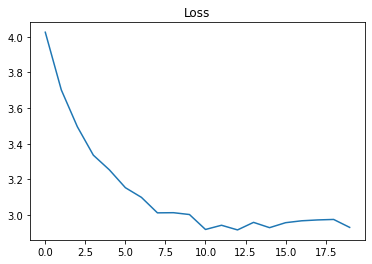

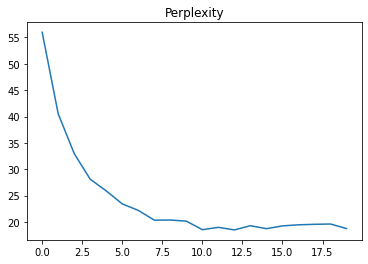

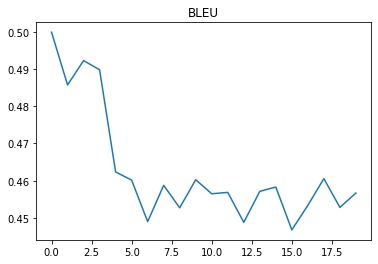

In [11]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=0, verbose=True)

num_epochs = 20
print_every = 1000



plt.plot(loss_list)
plt.title('Loss')
plt.show()

plt.plot(perplexity_list)
plt.title('Perplexity')
plt.show()

plt.plot(bleu_list)
plt.title('BLEU')
plt.show()

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
4it [00:00,  4.22it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
7it [00:01,  3.69it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
1000it [04:05,  4.07it/s]

0.45884709980203275 2.946205322742462 19.033590185114896


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


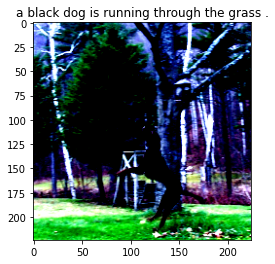

true captions
A black dog jumping .
A brown dog is jumping on its hind legs .
a brown dog is leaping into the air in front of a wooden structure in a pine forest .
a brown dog jumping off the ground in the woods
The dog leaps into the air in a field .


In [13]:
with torch.no_grad():
  dataiter = iter(test_data)
  img, _, true_captions = next(dataiter)
  #caps_true = test_dataset.get_last_captions()
  features = model.encoder(img[0:1].to(device))
  caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
  hyp_caption = ' '.join(caps[:-1])
  show_image(img[0], title=hyp_caption)
  print('true captions')
  for i in range(5):
    print(' '.join(true_captions[0][i]))

TypeError: ignored

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


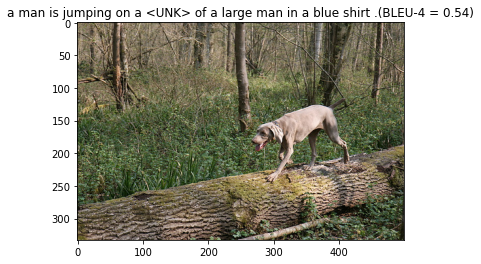

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


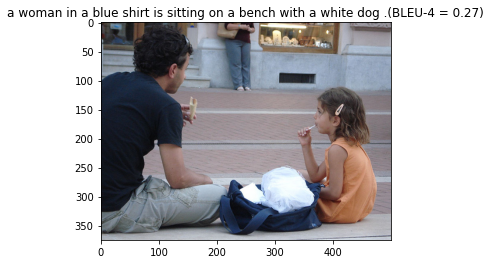

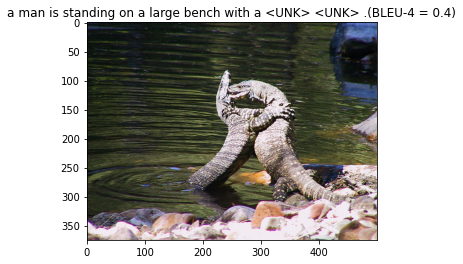

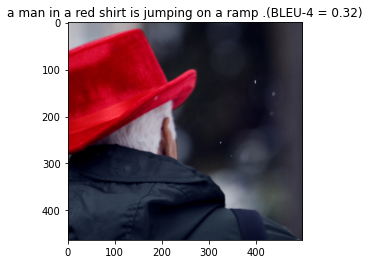

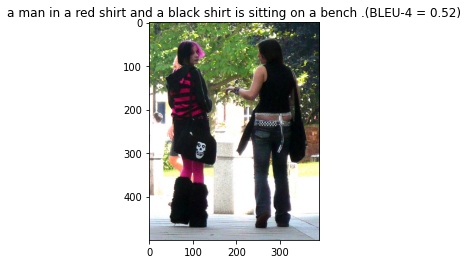

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


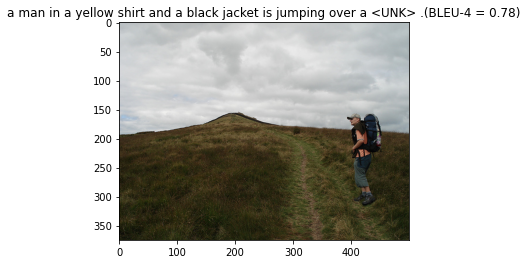

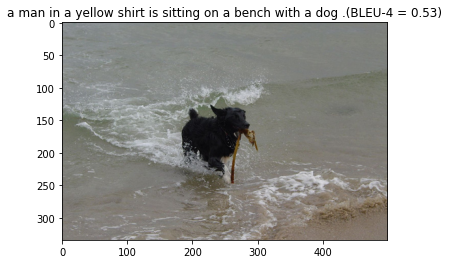

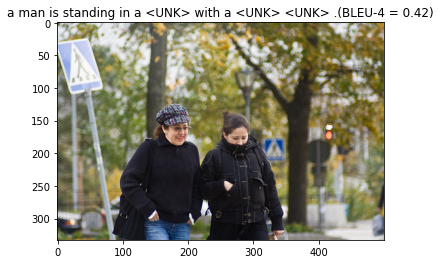

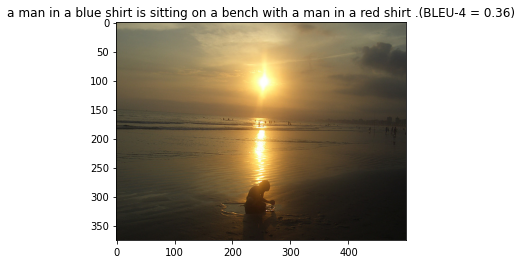

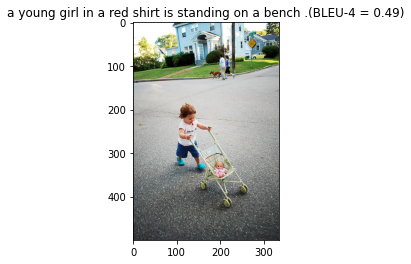

In [27]:
for idx in idxs:
  #open image & show
  im = Image.open(images_path +'/'+ test_dataset.imgs[idx])
  plt.imshow(im)
  # transform image & generate caption
  img = transforms(im).unsqueeze(0)
  features = model.encoder(img.to(device))
  caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
  hyp_caption = ' '.join(caps[:-1]) #to string
  # get all true 5 captions for our image:
  captions1 = test_dataset.captions[np.where(test_dataset.imgs == test_dataset.imgs[idx])[0]]
  # from strings to list of words
  all_captions = captions1 = [c.split(' ') for c in captions1]
  curr_blew_score = sentence_bleu(references=all_captions, hypothesis=hyp_caption.split())
  plt.title(hyp_caption + '(BLEU-4 = {})'.format(np.round(curr_blew_score,2)))
  plt.show()

In [14]:
# Hyperparams (with embeddings)
weights_matrix = None
# load pretrained embeddings: same dim as base model
g = GloVe(name='840B', dim=300)
embed_size = g.dim
weights_matrix = load_embedding_weights(vocab, g)

vocab_size = len(vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 3e-4

.vector_cache/glove.840B.300d.zip: 2.18GB [06:51, 5.29MB/s]                           
100%|█████████▉| 2194918/2196017 [03:30<00:00, 10971.27it/s]

In [17]:
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    embedding_weights = weights_matrix
).to(device)

pad_idx = vocab.stoi["<PAD>"]

using pretrained embedding weights


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, verbose=True)

num_epochs = 20
print_every = 1000
loss_list = []
perplexity_list = []
bleu_list = []
total_loss = 0
best_loss = 1000
for epoch in range(1, num_epochs + 1):
    model.train()
    avg_training_loss = train_one_epoch(model, train_data)
    print('average loss = {}'.format(avg_training_loss))

    model.eval()
    bleu, loss, perp = evaluate(model, val_data)
    print("Epoch: {} loss: {:.3f}, perplexity: {:.3f}, BLEU: {:.3f}".format(epoch, loss, perp, bleu))
    # save only best model based on evaluation loss
    if loss < best_loss:
      best_loss = loss
      save_model(model,'WithPreTrained', 1)#overrides previous saved model

    # reduce LR based on evaluation loss (because BLEU is not an accurate perf estimate)
    scheduler.step(loss)
    perplexity_list.append(perp)
    loss_list.append(loss)
    bleu_list.append(bleu)

    pickle.dump(perplexity_list, open('perplexity_list.p', 'wb'))
    pickle.dump(loss_list, open('loss_list.p', 'wb'))
    pickle.dump(bleu_list, open('blew_list.p', 'wb'))


plt.plot(loss_list)
plt.title('Loss')
plt.show()

plt.plot(perplexity_list)
plt.title('Perplexity')
plt.show()

plt.plot(bleu_list)
plt.title('BLEU')
plt.show()

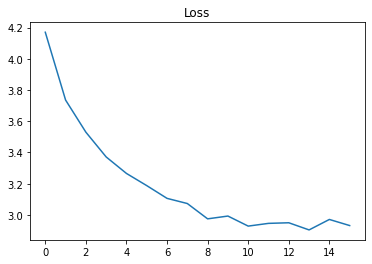

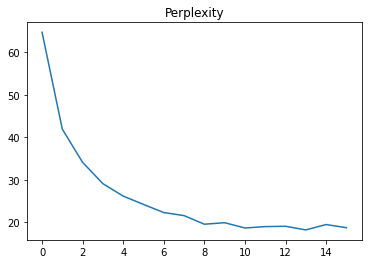

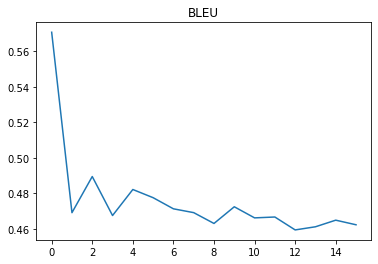

In [21]:
plt.plot(loss_list)
plt.title('Loss')
plt.show()

plt.plot(perplexity_list)
plt.title('Perplexity')
plt.show()

plt.plot(bleu_list)
plt.title('BLEU')
plt.show()

In [25]:
model1 = torch.load('caption_model_E_1.torch')

In [20]:
bleu, loss, perp = evaluate(model, test_data)
print(bleu,loss,perp)

0.47460237347292256 3.2819957163333893 26.62886336285401


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


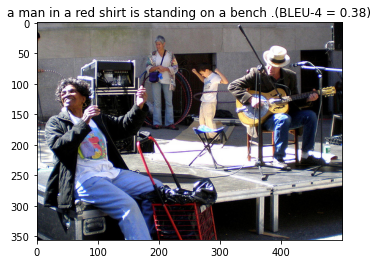

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


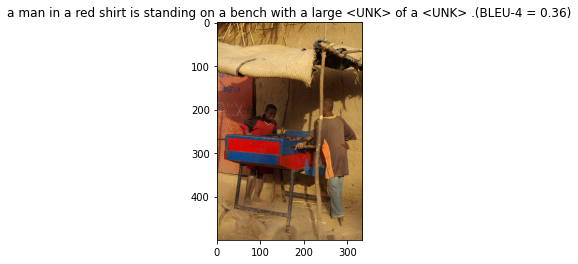

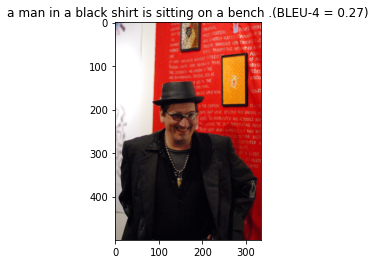

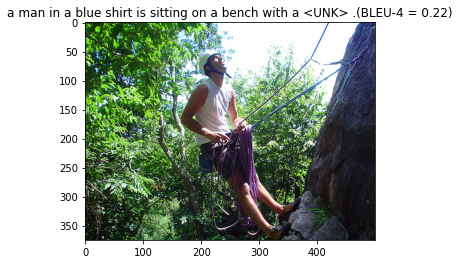

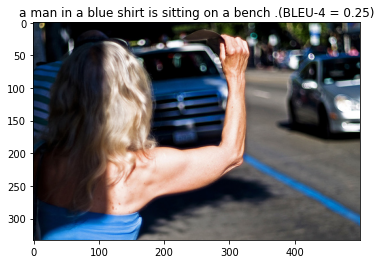

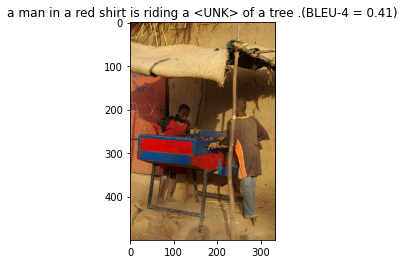

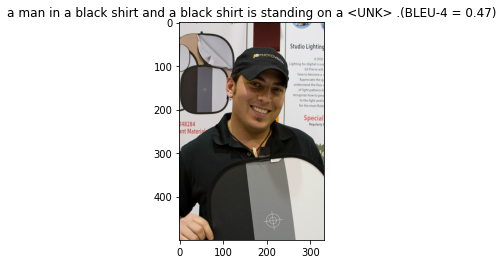

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


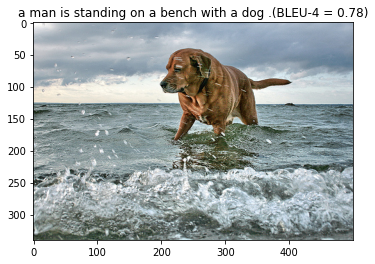

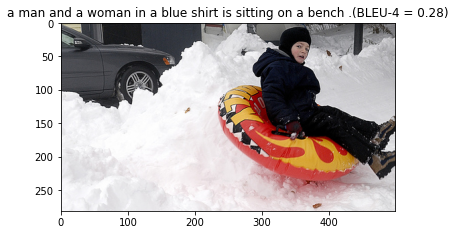

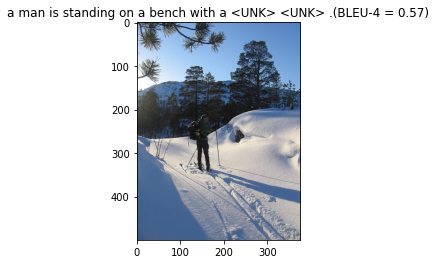

In [23]:
idxs = np.random.randint(size=10,low=0, high=len(test_dataset))#10 random idxs for plotting
for idx in idxs:
  #open image & show
  im = Image.open(images_path +'/'+ test_dataset.imgs[idx])
  plt.imshow(im)
  # transform image & generate caption
  img = transforms(im).unsqueeze(0)
  features = model.encoder(img.to(device))
  caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
  hyp_caption = ' '.join(caps[:-1]) #to string
  # get all true 5 captions for our image:
  captions1 = test_dataset.captions[np.where(test_dataset.imgs == test_dataset.imgs[idx])[0]]
  # from strings to list of words
  all_captions = captions1 = [c.split(' ') for c in captions1]
  curr_blew_score = sentence_bleu(references=all_captions, hypothesis=hyp_caption.split())
  plt.title(hyp_caption + '(BLEU-4 = {})'.format(np.round(curr_blew_score,2)))
  plt.show()
